## Modeling with Sklearn: Linear Regression
Covered:

- Fitting linear regression on numerical features
- Fitting linear regression on categorical features
- Fitting linear regression on both numerical and categorical features with pipeline
- Evaluating model performance with various metrics along with corss validation
- Perform Hyperparameter tuning
- Saving the best model and loading the saved model (with joblib and pickle)


**Predicting the insurance charge based on the insurance data of policy holders**

#### Import libraries

In [6]:
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# download data from google drive
! gdown 'https://drive.google.com/uc?id=1zlXc4ROkxT34RF9Y6oR6NUJhbDTeAyL3'

Downloading...
From: https://drive.google.com/uc?id=1zlXc4ROkxT34RF9Y6oR6NUJhbDTeAyL3
To: /content/medical_insurance.csv
100% 115k/115k [00:00<00:00, 57.9MB/s]


In [3]:
insurance_df = pd.read_csv('/content/medical_insurance.csv')

In [4]:
insurance_df.shape

(2772, 7)

In [8]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### EDA

In [9]:
insurance_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [11]:
# check for duplicate observations
insurance_df.duplicated().sum()

1435

In [ ]:
insurance_df[insurance_df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.590,0,no,northwest,1639.56310
1338,23,male,34.400,0,no,southwest,1826.84300
1339,56,female,39.820,0,no,southeast,11090.71780
1340,27,male,42.130,0,yes,southeast,39611.75770
1341,19,male,24.600,1,no,southwest,1837.23700
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [ ]:
insurance_df[insurance_df['charges']==1639.56310]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631
1581,19,male,30.59,0,no,northwest,1639.5631
1967,19,male,30.59,0,no,northwest,1639.5631


Out of 2772 observaations 1435 rows are found to be duplicate. In regression or classification tasks, duplicate entries can bias the model's performance metrics. Removing duplicates can help ensure the model's validity.

In [12]:
# drop duplicates
insurance_df.drop_duplicates(inplace=True)

In [13]:
insurance_df.shape

(1337, 7)

In [14]:
2772 - 1337

1435

While our dataset includes non-numeric features, Linear Regression typically operates with numerical data, requiring transformation of categorical variables into a compatible format. However, for the initial phase, let's proceed by fitting the Linear Regression model solely on the numeric data.

### Fitting Linear Regression On Numerical Data

In [15]:
from sklearn.compose import make_column_selector

In [16]:
categorical_features = make_column_selector(dtype_include='O')(insurance_df)
numerical_features = make_column_selector(dtype_exclude='O')(insurance_df)

In [19]:
# make_column_selector(dtype_include='float')(insurance_df)

['bmi', 'charges']

In [20]:
# create a new dataframe including only numeric features
df = insurance_df[numerical_features]

In [21]:
df.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [22]:
df.columns

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

In [ ]:
df[['age', 'bmi', 'charges']].describe()

,age,bmi,charges
count,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,13279.121487
std,14.044333,6.100468,12110.359656
min,18.000000,15.960000,1121.873900
25%,27.000000,26.290000,4746.344000
50%,39.000000,30.400000,9386.161300
75%,51.000000,34.700000,16657.717450
max,64.000000,53.130000,63770.428010


Now we will be fitting the model on the numeric features df only. Lets check if the data satisfies the assumptions of LinearReg.

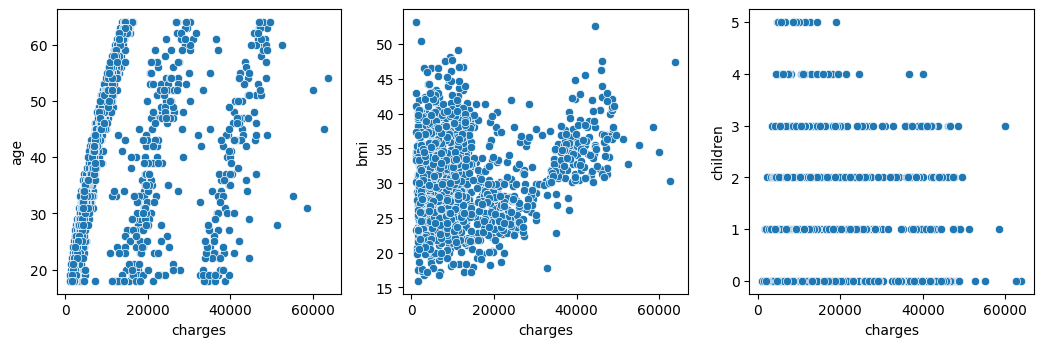

In [23]:
# Linearity check
plt.figure(figsize = (14, 10))
plotnumber = 1

for col in numerical_features:
    if plotnumber <= (len(numerical_features)-1):
        ax = plt.subplot(3, 4, plotnumber)
        sns.scatterplot(df, x=df['charges'], y=col)

    plotnumber += 1

plt.tight_layout()
plt.show()

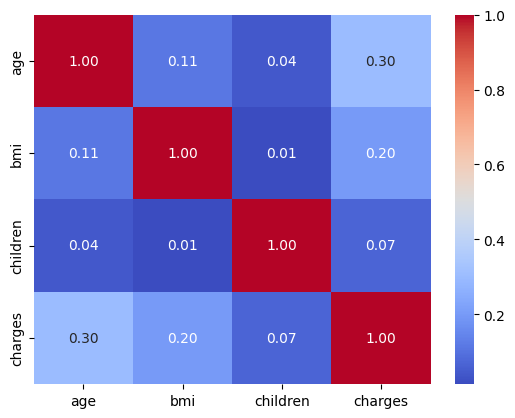

In [24]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f");

In the scatterplot and heatmap displayed above, it's evident that the target variable "charges" exhibits very weak to no correlation with the feature "children." Their relationship appears to be almost non-existent in terms of linearity. Consequently, it seems reasonable to exclude this feature from the model before proceeding with fitting

In [25]:
df.drop(columns=['children'], axis=1, inplace=True)

<ipython-input-25-60a4597b63d5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['children'], axis=1, inplace=True)


Now we left with only two dependent variables: age and bmi

In [ ]:
df.describe()

,age,bmi,charges
count,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,13279.121487
std,14.044333,6.100468,12110.359656
min,18.000000,15.960000,1121.873900
25%,27.000000,26.290000,4746.344000
50%,39.000000,30.400000,9386.161300
75%,51.000000,34.700000,16657.717450
max,64.000000,53.130000,63770.428010


In [26]:
df

,age,bmi,charges
0,19,27.900,16884.92400
1,18,33.770,1725.55230
2,28,33.000,4449.46200
3,33,22.705,21984.47061
4,32,28.880,3866.85520
...,...,...,...
1333,50,30.970,10600.54830
1334,18,31.920,2205.98080
1335,18,36.850,1629.83350
1336,21,25.800,2007.94500


In [27]:
# splitting the data into features and target
X = df.drop(columns=['charges'], axis=1)
y = df['charges']

In [ ]:
X.head()

,age,bmi
0,19,27.900
1,18,33.770
2,28,33.000
3,33,22.705
4,32,28.880


In [30]:
# Splittingg the data in train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, train_size=0.8, random_state=0)

In [34]:
X_train.shape, y_train.shape

((1069, 2), (1069,))

In [32]:
df.shape

(1337, 3)

In [36]:
from sklearn.linear_model import LinearRegression

lr_1 = LinearRegression()
lr_1.fit(X_train, y_train)

LinearRegression()

In [39]:
lr_1.intercept_

-4000.4926389069115

In [40]:
lr_1.coef_

array([224.67986614, 268.24479123])

In [41]:
# make prediction on test set
y_pred_1 = lr_1.predict(X_test)

In [44]:
lr_1.score(X_test, y_test)

0.16749968467793497

In [45]:
# model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,  r2_score

In [48]:
mean_absolute_error(y_test, y_pred_1)

9245.944320623112

In [46]:
print('MSE Linear Reg: ', mean_squared_error(y_test, y_pred=y_pred_1))
print('MAE Linear Reg: ', mean_absolute_error(y_test, y_pred=y_pred_1))
print('RMSE Linear Reg: ', mean_squared_error(y_test, y_pred=y_pred_1, squared=False))
print('R2-score Linear Reg: ', r2_score(y_test, y_pred=y_pred_1))

MSE Linear Reg:  140051167.54990542
MAE Linear Reg:  9245.944320623112
RMSE Linear Reg:  11834.321592296934
R2-score Linear Reg:  0.16749968467793497


In [49]:
# sklearn has provided score() function which returns the r2_score without having to pass predicted value
# it internally handles the prediction task
lr_1.score(X_test, y_test)

0.16749968467793497

r2 score being too low means that the mode is able to explain opnly 14% of variablility in target with independent variable.

The error metrics, along with the notably low R^2 score, suggest that the model's predictability is poor, explaining only 14% of the variability in the target variable using the independent variables.

We haven't scaled our data before fitting the model above. Scaling ensures that all features contribute equally to the model fitting process. Without scaling, features with larger scales may dominate the optimization process, leading to biased coefficient estimates.  Therefore, let's proceed by fitting the model after scaling the data.

##### Scaling numeric feattures

In [50]:
df.describe()

,age,bmi,charges
count,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,13279.121487
std,14.044333,6.100468,12110.359656
min,18.000000,15.960000,1121.873900
25%,27.000000,26.290000,4746.344000
50%,39.000000,30.400000,9386.161300
75%,51.000000,34.700000,16657.717450
max,64.000000,53.130000,63770.428010


In [52]:
from sklearn.preprocessing import StandardScaler


In [53]:
scaler = StandardScaler()


In [54]:
scaler

StandardScaler()

In [63]:
scaler.fit_transform(X)

array([[-1.44041773, -0.45315959],
       [-1.51164747,  0.50942165],
       [-0.79935006,  0.3831546 ],
       ...,
       [-1.51164747,  1.01448983],
       [-1.29795825, -0.79752426],
       [ 1.55123139, -0.26129928]])

In [68]:
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
# now fitting the model
lr_2 = LinearRegression()
lr_2.fit(X_train_scaled, y_train)

LinearRegression()

In [70]:
y_pred_2 = lr_2.predict(X_test_scaled)

In [71]:
lr_2.score(X_test_scaled, y_test)

0.16749968467793497

In [73]:
r2_score(y_test, y_pred_2)

0.16749968467793497

In [ ]:
print('R2-score Linear Reg: ', r2_score(y_test, y_pred=y_pred_2))

R2-score Linear Reg:  0.14154398499742504


Scaling the data didn't lead to an improved R^2 score. This could be because the original features already had relatively similar ranges, so scaling didn't introduce any noticeable differences. However, if the features had initially been in significantly different ranges, scaling would likely have helped improve the results.

r2 score of 0.141 suggests that only 14,1% of the variability in the target variable 'charge' can be explained by the independent variables. This indicates poor model performance.

The categorical features we excluded earlier might have had a significant relationship with the target variable, potentially improving our predictive capabilities. Therefore, let's reintroduce those features and fit the model with categorical features only for now.

### Fitting Linear Regression on Categorical Data

In [74]:
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [90]:
# make a copy of insuracne_df which has all type of features
df_2 = insurance_df.copy()
df_2.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Before fitting the model with categorical data, we must transform the categorical features into numeric form to ensure the model's comprehension.

To encode categorical features into numeric, scikit-learn has provided different encoding algorithms such as OrdinalEncoder, LabelEncoder, OneHotEncoder. This time we'll just be using the require encoding techniques, and won't dive in detail of every strategy. Details about all these encoding strategies will be covered in the next session.

In [91]:
df_2 = df_2[['sex', 'smoker', 'region', 'charges']]

In [92]:
df_2['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [93]:
from sklearn.preprocessing import OrdinalEncoder
# OneHotEncoder

In [94]:
enc = OrdinalEncoder()
enc.fit(df_2[['sex', 'smoker', 'region']])

OrdinalEncoder()

In [95]:
enc = OrdinalEncoder()
enc.fit(df_2[["sex","smoker", "region"]])
df_2[["sex","smoker", "region"]] = enc.transform(df_2[["sex","smoker", "region"]])

In [85]:
# df_2[["sex","smoker", "region"]] = enc.fit_transform(df_2[["sex","smoker", "region"]])

In [96]:
# Inspect the mapping between original categories and encoded labels
category_mapping = enc.categories_

for i, categories in enumerate(category_mapping):
    for j, category in enumerate(categories):
        print(f"Original cat: {category} -> Encoded label: {j}")


Original cat: female -> Encoded label: 0
Original cat: male -> Encoded label: 1
Original cat: no -> Encoded label: 0
Original cat: yes -> Encoded label: 1
Original cat: northeast -> Encoded label: 0
Original cat: northwest -> Encoded label: 1
Original cat: southeast -> Encoded label: 2
Original cat: southwest -> Encoded label: 3


In [97]:
df_2.head(10)

,sex,smoker,region,charges
0,0.0,1.0,3.0,16884.92400
1,1.0,0.0,2.0,1725.55230
2,1.0,0.0,2.0,4449.46200
3,1.0,0.0,1.0,21984.47061
4,1.0,0.0,1.0,3866.85520
5,0.0,0.0,2.0,3756.62160
6,0.0,0.0,2.0,8240.58960
7,0.0,0.0,1.0,7281.50560
8,1.0,0.0,0.0,6406.41070
9,0.0,0.0,1.0,28923.13692


<Axes: >

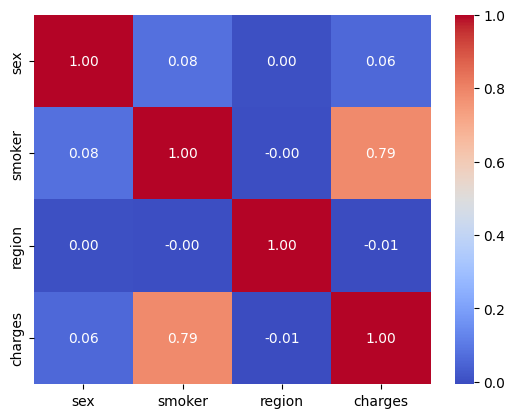

In [98]:
# correlation analysis
sns.heatmap(data=df_2.corr(), annot=True, cmap='coolwarm', fmt=".2f")

There is no significant correlation observed among the independent variables in the second dataset, indicating the absence of multicollinearity. Additionally, it's worth noting that, apart from the 'smoker' feature, none of the other features exhibit a correlation of even 0.1 with the target variable. Therefore, it may be advisable to drop features that show no linear relationship with the target variable.

Furthermore, we have observed a strong positive correlation between the feature `smoker` and the target variable `charges`. Hence, incorporating these features into the model is expected to yield improved predictions.

In [99]:
df_2.drop(columns=['sex', 'region'], axis=1, inplace=True)

In [100]:
df_2.head()

,smoker,charges
0,1.0,16884.92400
1,0.0,1725.55230
2,0.0,4449.46200
3,0.0,21984.47061
4,0.0,3866.85520


In [101]:
# splitting data in feature and target
X = df_2.drop(columns=['charges'], axis=1)
y = df_2[['charges']]

In [102]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
lr_3 = LinearRegression()
lr_3.fit(X_train, y_train)


LinearRegression()

In [104]:
y_pred_3 = lr_3.predict(X_test)
lr_3.score(X_test, y_test)

0.6732662703492575

In [105]:
lr_3.score(X_train, y_train)

0.5992794174747802

Obtaining an R-squared score of 0.67 on the test data indicates that approximately 67% of the variability in the target variable is explainable by the independent variables. This metric assesses the model's performance specifically on unseen data.

To further evaluate the model's generalization ability and ensure robustness, we'll employ cross-validation techniques. Cross-validation involves dividing the entire dataset into k folds (or subsets). Each fold gets a chance to serve as a test set with the remaining parts used as the training set. This process repeats k times, with each of the k folds used exactly once as the test set. It reduces bias and facilitates comprehensive use of data.


Scikit-learn provides two methods, `cross_validate` and `cross_val_score`, which split the data into multiple folds, bsed on the cv strategy we defined, and assess the model's performance across different subsets. `cross_validate` provides additional information like training scores, fit times, and score times, while `cross_val_score` solely returns the evaluation metric for the test set." This approach offers a more comprehensive understanding of how well the model performs on unseen data and helps guard against overfitting.

Setting cv=5 created 5 distinct splits to get 5 variations for the training and testing sets. Each training set is used to fit one model which is then scored on the matching test set.

Most commonly used cv strategies available in sklearn::
- K-Fold Cross-Validation
- Stratified K-Fold Cross-Validation
- Leave-One-Out Cross-Validation (LOOCV)
- Leave-P-Out Cross-Validation
- Time Series Cross-Validation
- Group K-Fold Cross-Validation

So, in overall, Cross Validation provides a robust methodology to assess whether a model is overfitting and helps you choose model configurations that generalize better.

In [109]:
from sklearn.model_selection import cross_validate, cross_val_score

cross_val_score(lr_3, X, y, cv=5)

array([0.61761433, 0.58330251, 0.63863085, 0.60431936, 0.64518506])

In [117]:
# Evalution with cross validation
from sklearn.model_selection import cross_validate
cv_result = cross_validate(lr_3, X,y, return_train_score=True)
cv_result

{'fit_time': array([0.00793529, 0.00937223, 0.00665283, 0.00568604, 0.00577426]),
 'score_time': array([0.00448465, 0.00522208, 0.00443363, 0.00395536, 0.00407815]),
 'test_score': array([0.61761433, 0.58330251, 0.63863085, 0.60431936, 0.64518506]),
 'train_score': array([0.62004193, 0.62738195, 0.61475077, 0.6236099 , 0.61305423])}

In [118]:
scores = cv_result['test_score']

print(
    "The mean cross-validation r2-score is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation r2-score is: 0.618 ± 0.023


In [120]:
#we can also specify the cv strategy but by default for classifcation it takes 5 fold stratifiesKFold and for regression it takes 5 fold KFold strategy
# also we can pass the metric which we want the model to monitor during cross validation
 # cross_validate tries to maximize its score so loss functions like MSE have to be negated.
from sklearn.model_selection import KFold, LeaveOneOut

cv = KFold(n_splits=3, shuffle=True, random_state=42)
cv_result = cross_validate(lr_3, X,y, cv=cv,  scoring='neg_mean_squared_error', return_train_score=True)
cv_result

{'fit_time': array([0.00786161, 0.00359249, 0.00356364]),
 'score_time': array([0.0027597 , 0.00291944, 0.00247216]),
 'test_score': array([-60780564.77165715, -55824673.5982178 , -55189761.32248814]),
 'train_score': array([-54093972.51561832, -55841905.76248241, -56323740.58281041])}

In [121]:
scores = cv_result['test_score']

print(
    "The mean cross-validation r2-score is: "
    f"{np.abs(scores.mean()):.3f} ± {scores.std():.3f}"
)

The mean cross-validation r2-score is: 57264999.897 ± 2499356.676


In [122]:
cv = LeaveOneOut()
cv_result = cross_validate(lr_3, X,y, cv=cv, scoring='neg_mean_squared_error', return_train_score=True)
cv_result

{'fit_time': array([0.00884175, 0.00479746, 0.00369096, ..., 0.00314713, 0.00325465,
        0.00332332]),
 'score_time': array([0.00350952, 0.00288558, 0.00236964, ..., 0.0021317 , 0.00233293,
        0.0020678 ]),
 'test_score': array([-2.31674531e+08, -4.51776358e+07, -1.59596774e+07, ...,
        -4.64747614e+07, -4.14577910e+07, -8.52363638e+06]),
 'train_score': array([-55596764.59050681, -55735757.00634311, -55757606.16209169, ...,
        -55734787.01730783, -55738538.70201385, -55763184.10774284])}

In [123]:
scores = cv_result['test_score']

print(
    "The mean cross-validation r2-score is: "
    f"{np.abs(scores.mean()):.3f} ± {scores.std():.3f}"
)

The mean cross-validation r2-score is: 55981207.439 ± 101715136.525


Cross-validation often yields lower or equal metrics compared to the train-test split method due to its comprehensive evaluation across different data subsets. While train-test split may result in slightly higher accuracy by optimizing for the test set, it risks overfitting. Thus, cross-validation provides a more robust assessment of generalization performance, balancing accuracy with a deeper understanding of model performance on unseen data

In [124]:
# evaluating using cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(lr_3, X,y)

array([0.61761433, 0.58330251, 0.63863085, 0.60431936, 0.64518506])

With cross validation we achieved 0.618 ± 0.023 r2-score.

Up to now, we've separately applied Linear Regression to both numeric and categorical features.

What if we include both numeric and categorical features as an input to model??


Let's attempt to reintroduce both categorical and numerical features and fit them into the model. Fitting the model with distinct dtype features and applying data preprocessing steps requires the use of a pipeline. Fortunately, sklearn provides `ColumnTransformer` that allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form a single feature space. This is useful for heterogeneous or columnar data, to combine several feature extraction mechanisms or transformations into a single transformer.

sklearn provides the `Pipeline` and `make_pipeline` functions to streamline this process, making our workflow more efficient.

Let's explore how they work.

### Fitting Linear Regression on Both Caegorical and Numerical Features Together

In [125]:
df_3 = insurance_df.copy()

In [126]:
df_3.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [127]:
# let's first drop the features that has very little correlation with target: sex, children and region
df_3.drop(columns=['sex', 'children', 'region'], axis=1, inplace=True)

In [128]:
# features and target
X = df_3.drop(columns=['charges'], axis=1)
y = df_3['charges']

In [129]:
X.head()

,age,bmi,smoker
0,19,27.900,yes
1,18,33.770,no
2,28,33.000,no
3,33,22.705,no
4,32,28.880,no


In [130]:
# Separate numerical and categorical features
cat_features = make_column_selector(dtype_include='O')(X)
num_features = make_column_selector(dtype_exclude='O')(X)

In [131]:
cat_features, num_features

(['smoker'], ['age', 'bmi'])

In [ ]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [132]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

In [139]:
# Define preprocessing steps
numeric_preprocessor = StandardScaler()
categoric_preprocessor = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [140]:
ColumnTransformer(
    [
        (numeric_preprocessor, num_features),
        (categoric_preprocessor, cat_features)
        ]
)

ColumnTransformer(transformers=[(StandardScaler(), ['age', 'bmi']),
                                (OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['smoker'])])

In [141]:
# Combine preprocessing steps to transform each features separately with their respective preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric-preprocessor', numeric_preprocessor, num_features),
        ('categoric-preprocessor', categoric_preprocessor, cat_features)
    ]
)



In [142]:
preprocessor

ColumnTransformer(transformers=[('numeric-preprocessor', StandardScaler(),
                                 ['age', 'bmi']),
                                ('categoric-preprocessor',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['smoker'])])

In [146]:
# Define the model
model = LinearRegression()

# pipeline = make_pipeline(preprocessor, model)

In [148]:
from sklearn.pipeline import make_pipeline, Pipeline

In [149]:
pipeline = make_pipeline(preprocessor, model)

In [150]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric-preprocessor',
                                                  StandardScaler(),
                                                  ['age', 'bmi']),
                                                 ('categoric-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['smoker'])])),
                ('linearregression', LinearRegression())])

In [ ]:
# Both the Pipeline and make_pipeline constructors from sklearn serve the same purpose, the only difference btwn these is:
# make_pipeline does not require, and does not permit, naming the estimators. Instead, their names will be set to the lowercase of their types automatically.
# whereas in pipeline we need to explicitly pass the name of the estimators along with estimator as a tuple

# pipeline = Pipeline([
#     ('data-preprocessor', preprocessor),
#     ('linear-regression', model)
# ])

# pipeline

In [151]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [152]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric-preprocessor',
                                                  StandardScaler(),
                                                  ['age', 'bmi']),
                                                 ('categoric-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['smoker'])])),
                ('linearregression', LinearRegression())])

In [153]:
pipeline.score(X_test, y_test)

0.8049502474643171

In [155]:
# Fit the model on the training data
pipeline.fit(X_train, y_train)
# Make predictions on the testing data
predictions = pipeline.predict(X_test)
# get r2 score
pipeline.score(X_test, y_test)


0.8049502474643171

In [156]:
# model evaluation with other metrics
print('MSE Linear Reg: ', mean_squared_error(y_test, predictions))
print('MAE Linear Reg: ', mean_absolute_error(y_test, predictions))
print('RMSE Linear Reg: ', mean_squared_error(y_test, predictions, squared=False))
print('R2 score Linear Reg: ', r2_score(y_test, predictions))

MSE Linear Reg:  35841574.818147525
MAE Linear Reg:  4191.704294603893
RMSE Linear Reg:  5986.783344847843
R2 score Linear Reg:  0.8049502474643171


In [157]:
# Evalution with cross validation
cv_result = cross_validate(pipeline, X,y, return_train_score=True)
cv_result

{'fit_time': array([0.02177095, 0.01478076, 0.00955153, 0.01277518, 0.01054215]),
 'score_time': array([0.00665736, 0.00535631, 0.00499678, 0.00596428, 0.00511479]),
 'test_score': array([0.76170322, 0.70980997, 0.77139554, 0.72830637, 0.75328972]),
 'train_score': array([0.74318665, 0.7551747 , 0.74092097, 0.75204658, 0.74562682])}

In [158]:
scores = cv_result['test_score']
print(
    "The mean cross-validation r2-score is: "
    f"{np.abs(scores.mean()):.3f} ± {scores.std():.3f}"
)

The mean cross-validation r2-score is: 0.745 ± 0.023


We evaluated the model on different folds of the dataset and got cross validation metric 0.745 ± 0.023. NOw let's look into how can the parameter of a model be tuned and best param be found with sklearn.

### Regularization - Strategies to prevent overfitting

Regularization is a technique in machine learning used to prevent overfitting, and it can effectively manage features with low predictive power (among other things) without the explicit need to manually drop them. So we'll not be dropping any of the features in below experiment.
- L1 (Lasso regression):  might reduce the coefficients of low-importance features to zero, effectively removing them from the model.
- L2 (Ridge regression):  decreases the impact of less important features, though it keeps all of them in the model.
- ElasticNet:  provides a balance by potentially removing some features and reducing the impact of others.

In [159]:
from sklearn.linear_model import Ridge, Lasso

In [160]:
df_4 = insurance_df.copy()

In [161]:
df_4.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [162]:
X = df_4.drop(columns=['charges'], axis=1)
y = df_4[['charges']]

In [163]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [ ]:
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [164]:
categorical_features = make_column_selector(dtype_include='O')(X)
numerical_features = make_column_selector(dtype_exclude='O')(X)

In [165]:
categorical_features

['sex', 'smoker', 'region']

In [166]:
numerical_features

['age', 'bmi', 'children']

In [167]:
df_4['children'].max(),  df_4['children'].min()

(5, 0)

In [168]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [169]:
from sklearn.preprocessing import OneHotEncoder

In [170]:
# need to scale numeric features and encode categoric features
scaler = StandardScaler()
encoder = OneHotEncoder()



In [171]:
# Create a transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


In [178]:
# Lasso regression shrinks the coffecient of least important features to zero
lasso = Lasso(alpha=1)

# Create a pipeline that first transforms the data and then fits the model
pipeline_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                           ('lasso', lasso)])

# Fit the model
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_test)
# r2-score
pipeline_lasso.score(X_test, y_test)

0.8068460476468182

In [174]:
# Ridge regression shrinks coffecient of less important features asymptotically to zero, it don't make to coefficeitn exactly 0
ridge = Ridge(alpha=1)

# Create a pipeline that first transforms the data and then fits the model
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                           ('ridge', ridge)])

# Fit the model
pipeline_ridge.fit(X_train, y_train)
# r2-score
pipeline_ridge.score(X_test, y_test)

0.8064140377474768

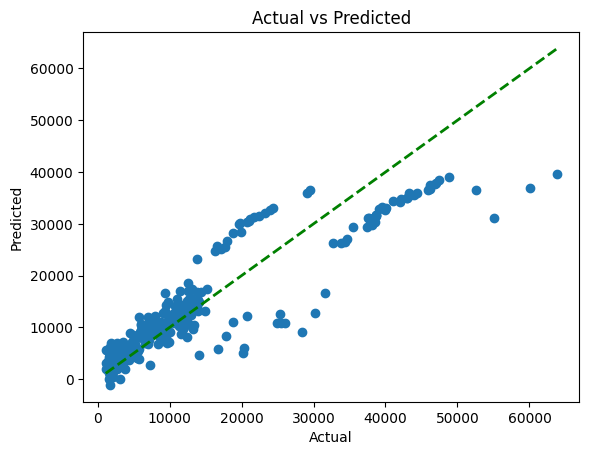

In [179]:
# Plot actual vs predicted
plt.scatter(y_test, y_pred_lasso)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2)  # Plot the diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

The linear models, including linear regression, lasso, and ridge, yielded only average results. This could be attributed to the inherent complexity and non-linearity of the data, where some features exhibit strong correlations (up to 0.79) with the target variable, while others show weaker correlations (ranging from 0.3 to 0.2). Consequently, these linear models may struggle to capture the intricate relationships present in the dataset, resulting in suboptimal performance. Thus, exploring more complex models like Random Forest could help to uncover and leverage these intricate patterns for better predictive accuracy, which will be covered in the next session

### Hyperparameter Tuning

Sklearn has provided various param tuning methodolies we will try to cover few in this notebook. Some of the most common strategies are: `GridsearchCV` and `RandomizedsearchCV`.

`GridSearchCV` exhaustively searches through all possible hyperparameter combinations, while `RandomizedSearchCV` randomly samples a subset of combinations. `.` guarantees finding the optimal combination but can be computationally expensive, while `RandomizedSearchCV` is more efficient but may not guarantee the best combination. The choice between the two depends on factors like the size of the search space, computational resources, and time constraints

In [180]:
from sklearn.model_selection import GridSearchCV
# RandomizedSearchCV


In [181]:
num_features, numeric_preprocessor

(['age', 'bmi'], StandardScaler())

In [183]:
cat_features, categoric_preprocessor

(['smoker'],
 OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

In [184]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'bmi', 'children']),
                                ('cat', OneHotEncoder(),
                                 ['sex', 'smoker', 'region'])])

In [185]:
param_grid = {'lasso__alpha': [0.3, 0.5, 0.7, 0.9, 1],
              'lasso__max_iter': [1000, 1500, 1800, 2000],
              'lasso__tol':[1e-4, 1e-5, 1e-6]}


In [198]:
# pipeline = make_pipeline([
#     (preprocessor),
#     (Lasso())
# ])

pipeline = make_pipeline(preprocessor, Lasso())


In [199]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('lasso', Lasso())])

In [200]:
X_train.shape

(1069, 6)

In [201]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': [0.3, 0.5, 0.7, 0.9, 1],
                         'lasso__max_iter': [1000, 1500, 1800, 2000],
                         'lasso__tol': [0.0001, 1e-05, 1e-06]})

In [204]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Score:", best_score)
# print("Best Estimator:", best_estimator)

Best Parameters: {'lasso__alpha': 1, 'lasso__max_iter': 1000, 'lasso__tol': 0.0001}
Best Score: 0.7467490657679969


In [205]:
best_estimator

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('lasso', Lasso(alpha=1))])

The R2-score we obtained with GridSearchCV (0.746) is lower than the default model setting. This could be because the model was initially evaluated on a specific train-test split, whereas GridSearchCV trains the model on different folds and evaluates it on different folds and the mean is computed later. There is often high chance of getting higher r2-score while evaluating model on a specific train-test split. If we were to assess the same model with cross-validation, the metric might differ from the previous evaluation.

In [208]:
# evaluating initial lasso model with cross validation
r2_result = cross_validate(pipeline_lasso, X_train, y_train, cv=5)
print(f"The mean cv r2-score is {r2_result['test_score'].mean():.3f} ± {r2_result['test_score'].std():.3f}")

The mean cv r2-score is 0.726 ± 0.025


### Save and Load the best model

##### Using joblib

In [215]:
import joblib

# best estimator can be saved directly
joblib.dump(grid_search.best_estimator_, 'lasso_best_model_.pkl')

['lasso_best_model_.pkl']

In [213]:
# else trainnig the model with the best param and can be saved
lasso_best = Lasso(alpha= 1, max_iter= 1000, tol= 0.0001)
lasso_best.fit(preprocessor.fit_transform(X_train), y_train)
lasso_best.score(preprocessor.transform(X_test), y_test)

0.8068460476468182

In [217]:
# dump model
joblib.dump(lasso_best, 'lasso_best_model_.pkl')

['lasso_best_model_.pkl']

In [212]:
# load model
saved_model = joblib.load('lasso_best_model_.pkl')
saved_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat', OneHotEncoder(),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('lasso', Lasso(alpha=1))])

#### Using pickle

In [218]:
import pickle

# Save the model to a file
with open('lasso_best_pickle.pkl', 'wb') as file:
    pickle.dump(lasso_best, file)

In [219]:
# Load the model from the file
with open('lasso_best_pickle.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [221]:
loaded_model

Lasso(alpha=1)

The linear models, including linear regression, lasso, and ridge, yielded only average results. This could be attributed to the inherent complexity and non-linearity of the data, where some features exhibit strong correlations (up to 0.79) with the target variable, while others show weaker correlations (ranging from 0.3 to 0.2). Consequently, these linear models may struggle to capture the intricate relationships present in the dataset, resulting in suboptimal performance. Thus, exploring more complex models like Random Forest could help to uncover and leverage these intricate patterns for better predictive accuracy, which will be covered in the next session

In [ ]:
# from sklearn.ensemble import RandomForestRegressor

In [ ]:
# rf = RandomForestRegressor()
# pipeline_rf = Pipeline([
#     ('preprocessor', preprocessor),
#     ('rf', rf)
# ])

In [ ]:
# pipeline_rf.fit(X_train, y_train)
# rf_y_pred = pipeline_rf.predict(X_test)
# pipeline_rf.score(X_test, y_test)

In [ ]:
# # Plot actual vs predicted
# plt.scatter(y_test, rf_y_pred)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g--', lw=2)  # Plot the diagonal line
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Actual vs Predicted')
# plt.show()